# Análise do Consumo Energético no Brasil: Regiões, Setores e Pernambuco

# Introdução

O presente trabalho tem como objetivo analisar o **consumo de energia elétrica no Brasil**, utilizando dados históricos por estado, tipo de consumo e população. Os conjuntos de dados empregados foram disponibilizados publicamente, incluindo informações detalhadas sobre o consumo de energia elétrica (`consumo_energia_eletrica.csv`), dados geográficos dos estados (`estado_regiao.csv`) e estimativas populacionais (`populacao.csv`).  

A integração desses conjuntos de dados permite realizar uma análise abrangente, contemplando aspectos **temporais, geográficos e demográficos** do consumo energético brasileiro. O estudo busca identificar padrões de crescimento, variações sazonais e diferenças entre os setores de consumo — residencial, comercial e industrial — bem como destacar particularidades regionais.  

Especificamente, a análise exploratória inclui:  
- Avaliação da qualidade dos dados, identificando registros duplicados e valores ausentes;  
- Estudo de séries temporais do consumo total e por tipo de energia;  
- Comparação do consumo entre regiões do país e entre setores residencial e industrial;  
- Identificação de tendências e variações, incluindo impactos de eventos externos, como a pandemia de COVID-19.  

Como parte do trabalho, o estado de **Pernambuco** recebeu atenção especial, permitindo comparar o crescimento do consumo residencial e industrial ao longo dos anos, destacando diferenças de estabilidade, volatilidade e resposta a fatores externos.  

O estudo visa fornecer **insights relevantes para planejamento energético, políticas públicas e estratégias de eficiência**, ressaltando a importância de compreender tanto a evolução histórica do consumo quanto as diferenças regionais e setoriais.


In [444]:
import pandas as pd
import calendar
import gzip
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Loading dos dados

Os conjuntos de dados do consumo de energia e estados e regiçao utilizados neste projeto foram disponibilizados publicamente em http://leandrolessa.com.br/datasets/.<br />
O conjunto de dados da população foi disponibilizado pelo publicamente em https://basedosdados.org/dataset/d30222ad-7a5c-4778-a1ec-f0785371d1ca?table=0c279444-165b-41da-92cd-50fd7e66baa1

Eles reúnem informações relacionadas ao consumo de energia elétrica no Brasil e às características geográficas dos estados, possibilitando análises exploratórias de dados, estudos regionais e modelagem de séries temporais.

##### consumo_energia_eletrica.csv
Este conjunto de dados históricos compreende dados de consumo de eletricidade coletados ao longo de vários anos e agregados por estado, tornando-o adequado para análise exploratória de dados e estudos de séries temporais.

##### estado_regiao.csv
Este conjunto de dados fornece informações estruturadas sobre os estados brasileiros, abrangendo a identificação do estado, suas respectivas regiões geográficas e o país.

##### populacao.csv
Este conjunto de dados contém estimativas populacionais para o Brasil por estado, abrangendo o período de 1991 a 2021.


In [510]:
# loading data from CSV files into pandas DataFrames

consumption_df = pd.read_csv('./consumo_energia_eletrica.csv')
states_df = pd.read_csv('./estado_regiao.csv', encoding='latin1', sep=';')

with gzip.open('./populacao.csv', 'rb') as f_in:
    population_df = pd.read_csv(f_in)


# Análise exploratória

### Dataframe de consumo de energia elétrica

In [448]:
consumption_df.shape

(39897, 6)

In [449]:
consumption_df.dtypes

ano                      int64
mes                      int64
sigla_uf                object
tipo_consumo            object
numero_consumidores    float64
consumo                  int64
dtype: object

In [450]:
consumption_df.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624


In [451]:
print(consumption_df['tipo_consumo'].unique())

['Total' 'Cativo' 'Outros' 'Comercial' 'Industrial' 'Residencial']


In [452]:
print(consumption_df['sigla_uf'].unique())

['TO' 'BA' 'PR' 'RS' 'GO' 'MA' 'PI' 'RO' 'DF' 'SE' 'MG' 'MS' 'RJ' 'PA'
 'PE' 'RR' 'RN' 'AL' 'ES' 'AM' 'MT' 'AC' 'AP' 'SC' 'SP' 'PB' 'CE']


In [453]:
consumption_df.describe()

,ano,mes,numero_consumidores,consumo
count,39897.000000,39897.000000,2.693700e+04,3.989700e+04
mean,2013.742161,6.505752,6.954567e+05,6.076862e+05
std,5.886017,3.454432,1.869920e+06,1.198425e+06
min,2004.000000,1.000000,5.200000e+01,3.540000e+02
25%,2009.000000,4.000000,1.874100e+04,8.559200e+04
50%,2014.000000,7.000000,1.084390e+05,2.197670e+05
75%,2019.000000,10.000000,4.581500e+05,5.946410e+05
max,2023.000000,12.000000,1.920126e+07,1.280974e+07


### Análise estatística

In [454]:
# Exibir o tamanho máximo, mínimo e o desvio padrão do consumo em uma escala com valores em milhares

estatistico_df = consumption_df.copy()
estatistico_df['consumo_k'] = estatistico_df['consumo'] / 1_000

print("\nConsumo mínimo:")
min_value = estatistico_df['consumo_k'].min()
print(min_value)

print("\nConsumo máximo:")
max_value = estatistico_df['consumo_k'].max()
print(max_value)

print("\nMédia de consumo:")
mean_value = estatistico_df['consumo_k'].mean()
print(mean_value)

print("\nMediana de consumo:")
median_value = estatistico_df['consumo_k'].median()
print(median_value)

print("\nDesvio padrão:")
sdt_value = estatistico_df['consumo_k'].std()
print(sdt_value)



Consumo mínimo:
0.354

Consumo máximo:
12809.742

Média de consumo:
607.6861500363436

Mediana de consumo:
219.767

Desvio padrão:
1198.4246625035896


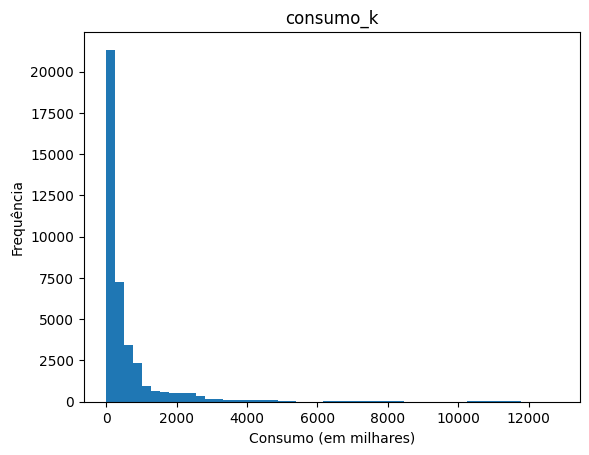

In [455]:
def plt_hist(df, title, field, x_label, is_log=False):
    df[field].plot(kind='hist', bins=50, log=is_log)
    plt.xlabel(x_label)
    plt.ylabel('Frequência')
    plt.title(field)
    
    plt.show()

plt_hist(estatistico_df, 'Distribuição do consumo', 'consumo_k', 'Consumo (em milhares)')

<strong>O histograma mostra a distribuição do consumo (em milhares) do conjunto de dados. A maior parte dos registros concentra-se em valores baixos, enquanto alguns registros apresentam consumo extremamente alto, evidenciando outliers e assimetria positiva.</strong>

<strong>A escala logarítmica no eixo Y foi utilizada para permitir visualizar tanto os valores mais frequentes quanto os menos comuns, tornando a distribuição completa mais legível. Esse gráfico ajuda a entender a variabilidade dos dados e a presença de registros extremos que elevam o desvio padrão.</strong>

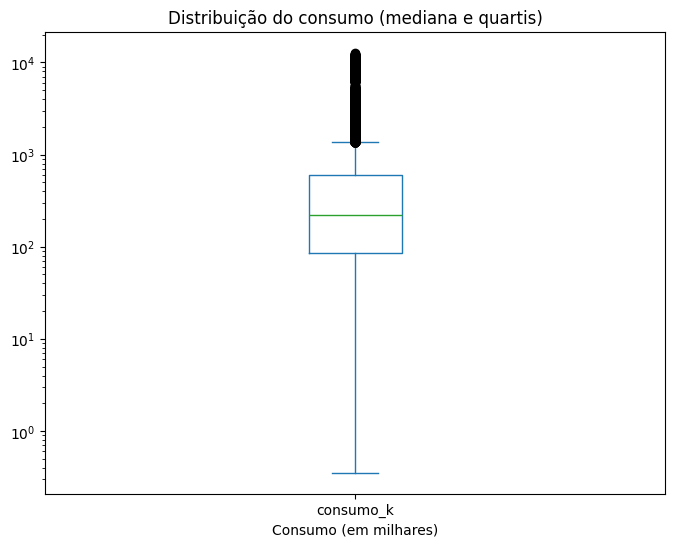

In [456]:
plt.figure(figsize=(8,6))
estatistico_df['consumo_k'].plot(kind='box',logy=True)

plt.xlabel('Consumo (em milhares)')
plt.title('Distribuição do consumo (mediana e quartis)')
plt.show()

<strong>Boxplot do consumo (em milhares) em escala logarítmica. A linha central indica a mediana, enquanto os outliers destacam consumos extremamente altos ou baixos, evidenciando a assimetria da distribuição.</strong>

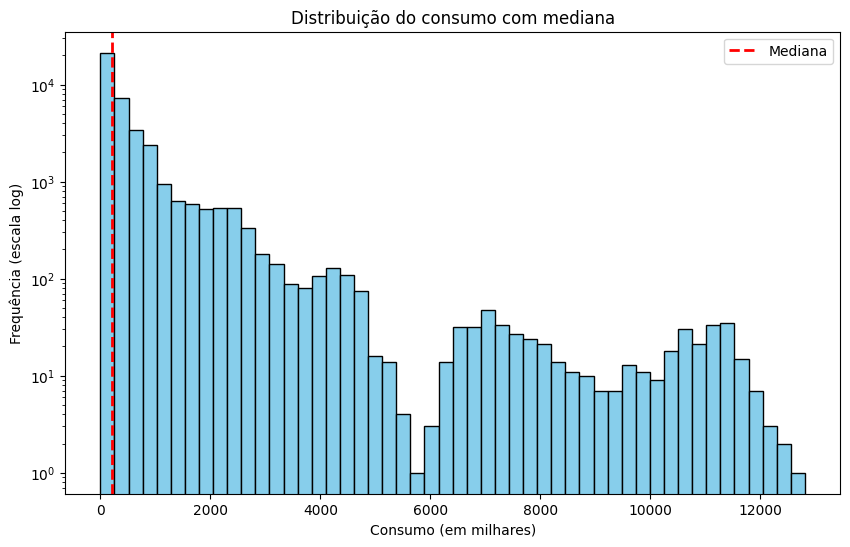

In [457]:
plt.figure(figsize=(10,6))
plt.hist(estatistico_df['consumo_k'], bins=50, log=True, color='skyblue', edgecolor='black')
plt.axvline(estatistico_df['consumo_k'].median(), color='red', linestyle='dashed', linewidth=2, label='Mediana')
plt.xlabel('Consumo (em milhares)')
plt.ylabel('Frequência (escala log)')
plt.title('Distribuição do consumo com mediana')
plt.legend()
plt.show()

<strong>Histograma do consumo com escala logarítmica no eixo Y. A linha vermelha indica a mediana (~219,767 mil), mostrando o consumo típico, enquanto os registros mais altos evidenciam outliers e a assimetria da distribuição.</strong>

<strong>Os dados de consumo apresentam outliers significativos, evidenciados pela grande diferença entre a mediana (~219,767 mil) e a média (~607,686 mil), e pela cauda longa à direita no histograma.
Esses outliers superiores correspondem a consumos extremamente altos, possivelmente em estados mais populosos, meses de pico ou com grande consumo industrial. Já os valores muito baixos (~0,354 mil) representam outliers inferiores, que podem refletir estados com menor população, períodos atípicos ou registros incompletos.</strong>

In [458]:
# visualizar a matriz de correlação dos dados numéricos

colunas_corr = ['ano', 'mes', 'numero_consumidores', 'consumo']
corr_matriz = estatistico_df[colunas_corr].corr()

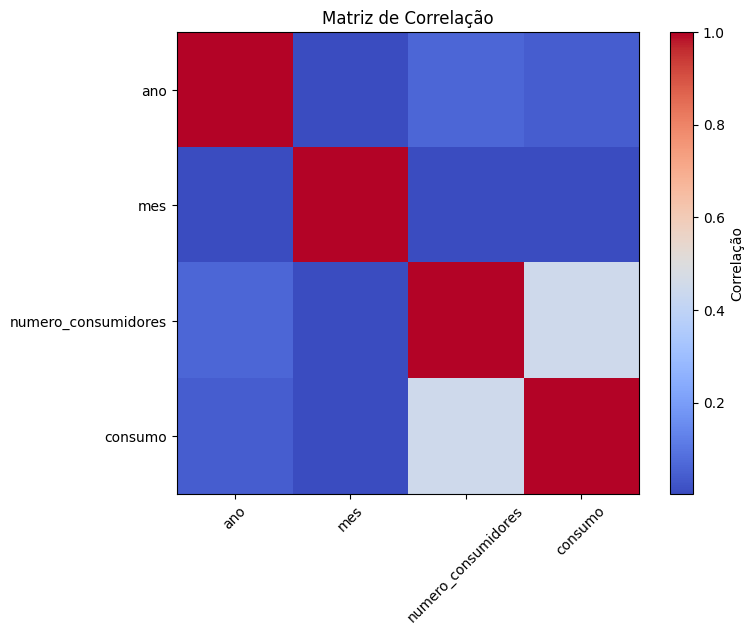

In [459]:
plt.figure(figsize=(8,6))
plt.imshow(corr_matriz, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlação')
plt.xticks(range(len(colunas_corr)), colunas_corr, rotation=45)
plt.yticks(range(len(colunas_corr)), colunas_corr)
plt.title('Matriz de Correlação')
plt.show()

<strong>A correlação entre as variáveis indica que o número de consumidores e o consumo possuem uma relação positiva moderada (≈0,45), sugerindo que o aumento de consumidores tende a aumentar o consumo.</strong>

### Verificar campos nulos
Com base na análise anterior, ficou claro que o campo `numero_consumidores` contém valores nulos. Nesse caso, analisarei e tentarei descobrir se existem outros campos com valores zero.

In [460]:
null_df = consumption_df.isnull()
print(null_df.sum())
print(f'\nTotal number of missing values for the numero_consumidores field: {null_df['numero_consumidores'].sum()}')

ano                        0
mes                        0
sigla_uf                   0
tipo_consumo               0
numero_consumidores    12960
consumo                    0
dtype: int64

Total number of missing values for the numero_consumidores field: 12960


In [461]:
# filter numero_consumidores null
consumption_null_filtered = consumption_df[consumption_df['numero_consumidores'].isnull()]
consumption_type_nulls = consumption_null_filtered['tipo_consumo'].unique()

print("Tipos de consumo com número nulo de consumidores:", consumption_type_nulls)

Tipos de consumo com número nulo de consumidores: ['Total' 'Cativo']


##### <strong>Após a análise, percebemos que os números de consumidores (`numero_consumidores`) que contêm dados de tipo de consumo nulos (`tipo_consumo`) são Cativo e Total.</strong>

### Verificar registros duplicados

In [462]:
duplicated_consumption_df = consumption_df.duplicated()
print(f'\nNúmero total de linhas duplicadas no dataframe de consumo de energia: {duplicated_consumption_df.sum() }')


Número total de linhas duplicadas no dataframe de consumo de energia: 1017


### Conclusão
Uma análise exploratória inicial do DataFrame de consumo de eletricidade indica que ele contém seis variáveis ​​— ano, mês, sigla_uf, tipo_consumo, numero_consumidores e consumo — totalizando 39.897 registros.

Foram identificados 1.017 registros duplicados, correspondendo a aproximadamente 2,5% do conjunto de dados. O campo numero_consumidores contém 12.960 valores ausentes, representando cerca de 32,5% dos registros, o que requer atenção especial em análises subsequentes.

Analisando os valores de consumo, observou-se que a distribuição apresenta grande variação, com consumos que vão de aproximadamente 0,354 mil a 12.809,742 mil. A mediana (~ 219,767 mil) é significativamente menor que a média (~607,686 mil), evidenciando a presença de outliers superiores, ou seja, estados ou períodos com consumos extremamente altos. Também existem valores muito baixos, que podem representar registros atípicos ou estados com menor consumo. Esses outliers influenciam as estatísticas médias, mas também fornecem informações importantes sobre padrões extremos e heterogeneidade do consumo entre estados e períodos.

### Dataframe estados e regiões

In [463]:
states_df.shape

(27, 5)

In [464]:
states_df.dtypes

id_estado     int64
sigla        object
estado       object
regiao       object
pais         object
dtype: object

In [465]:
states_df.head(27)

,id_estado,sigla,estado,regiao,pais
0,1,AC,Acre,Norte,Brasil
1,2,AL,Alagoas,Nordeste,Brasil
2,3,AP,Amapá,Norte,Brasil
3,4,AM,Amazonas,Norte,Brasil
4,5,BA,Bahia,Nordeste,Brasil
5,6,CE,Ceará,Nordeste,Brasil
6,7,DF,Distrito Federal,Centro-Oeste,Brasil
7,8,ES,Espírito Santo,Sudeste,Brasil
8,9,GO,Goiás,Centro-Oeste,Brasil
9,10,MA,Maranhão,Nordeste,Brasil


In [466]:
# Verificar registros nulos

null_df = states_df.isnull()
print(null_df.sum())

id_estado    0
sigla        0
estado       0
regiao       0
pais         0
dtype: int64


### Dataframe população

In [467]:
population_df.shape

(837, 4)

In [468]:
population_df.dtypes

sigla_uf                           object
ano                                 int64
populacao                           int64
populacao_economicamente_ativa    float64
dtype: object

In [469]:
population_df.head()

,sigla_uf,ano,populacao,populacao_economicamente_ativa
0,AC,1991,417102,NaN
1,AL,1991,2512658,NaN
2,AM,1991,2102766,NaN
3,AP,1991,289035,NaN
4,BA,1991,11867336,NaN


In [470]:
null_df = population_df.isnull()

print(null_df.sum())

sigla_uf                            0
ano                                 0
populacao                           0
populacao_economicamente_ativa    567
dtype: int64


In [471]:
population_df['sigla_uf'].unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [472]:
# Removendo a coluna populacao_economicamente_ativa

del population_df['populacao_economicamente_ativa']

In [473]:
population_df.head()

,sigla_uf,ano,populacao
0,AC,1991,417102
1,AL,1991,2512658
2,AM,1991,2102766
3,AP,1991,289035
4,BA,1991,11867336


<strong>Em relação ao campo da população economicamente ativa (`populacao_economicamente_ativa`), não achei os dados iniciais confiáveis, então vou descartá-lo do dataframe e não prosseguir com essa abordagem.</strong>

# Tratando dados duplicados

Conforme observado na análise exploratória inicial, foram identificados registros duplicados no DataFrame de consumo de eletricidade. Após a remoção das duplicatas, o DataFrame passou a conter 38.880 registros.

In [474]:
duplicated_df = consumption_df[duplicated_consumption_df]
print(duplicated_df)

        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
38880  2023   11       MS       Outros              99710.0   122350
38881  2023   11       RN       Outros              77359.0   112767
38882  2023   11       PE       Outros             157848.0   256509
38883  2023   11       ES       Outros             234985.0   180315
38884  2023   11       AC       Outros              23068.0    26323
...     ...  ...      ...          ...                  ...      ...
39892  2023   12       BA  Residencial            5932740.0   718461
39893  2023   12       PA  Residencial            2614106.0   478726
39894  2023   12       AC  Residencial             245699.0    58301
39895  2023   12       RN  Residencial            1390080.0   210119
39896  2023   12       SC  Residencial            2719791.0   655389

[1017 rows x 6 columns]


#### remove duplicate rows

In [475]:
consumption_transformed_df = consumption_df.drop_duplicates()

validate_duplicated_df = consumption_transformed_df.duplicated()
print(f'\nTotal number of duplicate lines in the energy consumption dataframe after remove duplicates: {validate_duplicated_df.sum() }')

consumption_transformed_df.shape


Total number of duplicate lines in the energy consumption dataframe after remove duplicates: 0


(38880, 6)

# Tratando dados ausentes
Conforme analisado anteriormente, o conjunto de dados `numero_consumidores` contém dados ausentes/nulos, e foi identificado que esses dados ausentes existem apenas para os tipos de consumo `Cativo` e `Total`. Analisarei os dados para entender o motivo dos valores zero e tentar encontrar alguma relação; caso não tenha sucesso, removerei os dados ausentes.

#### tipo_consumo Cativo

In [476]:
# function to count tipo_consumo Cativo missing values
def count_consumpion_type_captive(df, consumption_type): 
    df = df[df["tipo_consumo"] == consumption_type]    
    return df["numero_consumidores"].isna().sum()

count_captive = count_consumpion_type_captive(consumption_transformed_df, 'Cativo')
print(f'\nTotal number of missing values for the numero_consumidores field with Cativo tipo_consumo: {count_captive}')

# removing tipo_consumo Cativo from dataframe
consumption_transformed_df = consumption_transformed_df[~((consumption_transformed_df["tipo_consumo"] == "Cativo") & (consumption_transformed_df["numero_consumidores"].isna()))]

count_captive = count_consumpion_type_captive(consumption_transformed_df, 'Cativo')
print(f'\nTotal number of missing values for the numero_consumidores field with Cativo tipo_consumo: {count_captive}')


Total number of missing values for the numero_consumidores field with Cativo tipo_consumo: 6480

Total number of missing values for the numero_consumidores field with Cativo tipo_consumo: 0


<strong>Ao analisar os registros do dataframe com valores zero para consumo próprio, percebi que, embora fosse possível estimar o número de consumidores usando diversas técnicas estatísticas, essa abordagem não é adequada. Isso ocorre porque o consumo próprio abrange categorias distintas — residencial, comercial e pequenas indústrias — que estão separadas no dataframe. Portanto, inferir valores poderia gerar distorções e conclusões incorretas. Assim, optarei por remover os registros de consumo próprio da análise.</strong>

#### tipo_consumo Total

In [477]:
# count
count_captive = count_consumpion_type_captive(consumption_transformed_df, 'Total')
print(f'\nTotal number of missing values for the numero_consumidores field with Total tipo_consumo: {count_captive}')


Total number of missing values for the numero_consumidores field with Total tipo_consumo: 6480


In [478]:
# filter for the state of Pernambuco (PE) in February 2022, and then divided into two groups: one showing the total consumption and the other showing all the other types of consumption. 
    
consumption_pe_22 = consumption_transformed_df.query(
    "ano == 2022 and mes == 2 and sigla_uf == 'PE'"
)

total_df = consumption_pe_22[consumption_pe_22['tipo_consumo'] == 'Total']
others_df = consumption_pe_22[consumption_pe_22['tipo_consumo'] != 'Total']

print("Total consumption:")
print(total_df)

print("\nOther consumption types:")
print(others_df)

# sum comsumptions
total_consumo_others = others_df['consumo'].sum()
total_consumo = total_df['consumo'].sum()

# print total
print("\nTotal consumption for other types:", total_consumo_others)
print("\nTotal consumption for total types:", total_consumo)

Total consumption:
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
35031  2022    2       PE        Total                  NaN  1282724

Other consumption types:
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
35679  2022    2       PE       Outros             171780.0   255068
35995  2022    2       PE    Comercial             226681.0   248323
36325  2022    2       PE   Industrial               4821.0   321438
36652  2022    2       PE  Residencial            3482337.0   457895

Total consumption for other types: 1282724

Total consumption for total types: 1282724


In [479]:
# filter for the state of Pernambuco (PE) in February 2022, and then divided into two groups: one showing the total consumption and the other showing all the other types of consumption. 
    
consumo_pe_22 = consumption_transformed_df.query(
    "ano == 2021 and mes == 3 and sigla_uf == 'CE'"
)

total_df = consumo_pe_22[consumo_pe_22['tipo_consumo'] == 'Total']
others_df = consumo_pe_22[consumo_pe_22['tipo_consumo'] != 'Total']

print("Total consumption:")
print(total_df)

print("\nOther consumption types:")
print(others_df)

# sum comsumptions
total_consumo_others = others_df['consumo'].sum()
total_consumo = total_df['consumo'].sum()

# print total
print("\nTotal consumption for other types:", total_consumo_others)
print("\nTotal consumption for total types:", total_consumo)

Total consumption:
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
33102  2021    3       CE        Total                  NaN  1015890

Other consumption types:
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
33775  2021    3       CE       Outros             738531.0   215326
34097  2021    3       CE    Comercial             203806.0   184112
34416  2021    3       CE   Industrial               7808.0   207590
34739  2021    3       CE  Residencial            3436862.0   408862

Total consumption for other types: 1015890

Total consumption for total types: 1015890


In [480]:
# separate the Total consumption types from the other types

consumption_transformed_df = consumption_transformed_df[consumption_transformed_df["tipo_consumo"] != "Total"]

consumption_total_df = consumption_transformed_df.groupby(
    ["ano", "mes", "sigla_uf"], as_index=False
).agg({
    "numero_consumidores": "sum",
    "consumo": "sum"
})

consumption_total_df["tipo_consumo"] = "Total"

consumption_total_df = consumption_total_df[["ano", "mes", "sigla_uf", "tipo_consumo", "numero_consumidores", "consumo"]]

# show tipo_consumo from consumption_total_df
print(consumption_transformed_df['tipo_consumo'].unique())

# show tipo_consumo from consumption_transformed_df
print(consumption_total_df.head())
print(consumption_total_df['tipo_consumo'].unique())

['Outros' 'Comercial' 'Industrial' 'Residencial']
    ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
0  2004    1       AC        Total             126275.0    34839
1  2004    1       AL        Total             637016.0   285489
2  2004    1       AM        Total             543155.0   274773
3  2004    1       AP        Total             114101.0    43084
4  2004    1       BA        Total            3502266.0  1444449
['Total']


In [481]:
# filter for the state of Pernambuco (PE) in February 2022, and then divided into two groups: one showing the total consumption and the other showing all the other types of consumption. 
    
consumption_pe_22 = consumption_transformed_df.query(
    "ano == 2022 and mes == 2 and sigla_uf == 'PE'"
)

consumption_total_pe_22 = consumption_total_df.query(
    "ano == 2022 and mes == 2 and sigla_uf == 'PE'"
)

others_df = consumption_pe_22[consumption_pe_22['tipo_consumo'] != 'Total']
total_df = consumption_total_pe_22[consumption_total_pe_22['tipo_consumo'] == 'Total']

print("Total consumption:")
print(total_df)

print("\nOther consumption types:")
print(others_df)

# sum comsumptions
total_consumo_others = others_df['consumo'].sum()
total_consumo = total_df['consumo'].sum()

# print total
print("\nTotal consumption for other types:", total_consumo_others)
print("\nTotal consumption for total types:", total_consumo)

print("\nTotal numero_consumidores for other types:", others_df['numero_consumidores'].sum())
print("\nTotal numero_consumidores for total types:", total_df['numero_consumidores'].sum())

Total consumption:
       ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
5874  2022    2       PE        Total            3885619.0  1282724

Other consumption types:
        ano  mes sigla_uf tipo_consumo  numero_consumidores  consumo
35679  2022    2       PE       Outros             171780.0   255068
35995  2022    2       PE    Comercial             226681.0   248323
36325  2022    2       PE   Industrial               4821.0   321438
36652  2022    2       PE  Residencial            3482337.0   457895

Total consumption for other types: 1282724

Total consumption for total types: 1282724

Total numero_consumidores for other types: 3885619.0

Total numero_consumidores for total types: 3885619.0


<strong>Conclui que o numero_consumidores para o tipo de consumo Total está vazio porque representa a soma de todos os outros tipos de consumo. O dataframe será agora dividido em dois: um contendo apenas o tipo de consumo Total e o outro contendo todos os outros tipos de consumo.</strong>

# Visualização do consumo a partir dos tipos de consumo

##### Consumo indistrial

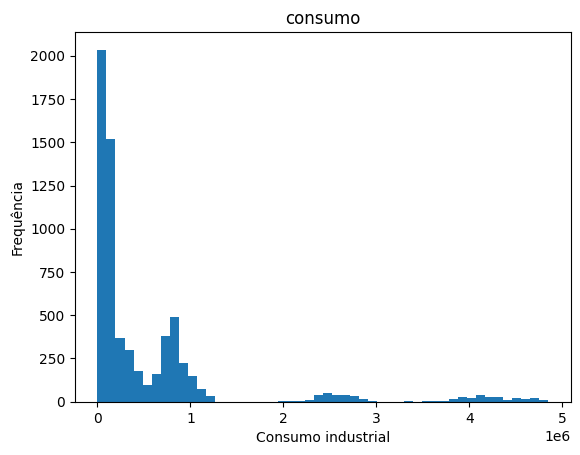

,ano,mes,numero_consumidores,consumo
count,6480.000000,6480.000000,6480.000000,6.480000e+03
mean,2013.500000,6.500000,19331.947685,5.344922e+05
std,5.766726,3.452319,31049.445915,9.009075e+05
min,2004.000000,1.000000,52.000000,3.540000e+02
25%,2008.750000,3.750000,2290.750000,5.601125e+04
50%,2013.500000,6.500000,5211.000000,1.625300e+05
75%,2018.250000,9.250000,15942.000000,7.414490e+05
max,2023.000000,12.000000,140497.000000,4.849895e+06


In [482]:
# histograma para o tipo de consumo industrial
plt_hist(consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Industrial'], 'Distribuição do consumo', 'consumo', 'Consumo industrial')
consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Industrial'].describe()

<strong>O número de consumidores industriais de energia elétrica varia bastante. A média é de 19.331 consumidores, com a mediana sendo de 5.211 consumidores. O valor mínimo foi de 52 consumidores, enquanto o valor máximo chegou a 140.497 consumidores. Esse padrão mostra uma grande diversidade no porte das indústrias que consomem energia.</strong>

<strong>O consumo de energia elétrica no setor industrial apresenta grande variação ao longo do tempo. A média mensal de consumo é de aproximadamente 534 mil unidades, enquanto a mediana é de 162,5 mil unidades, indicando que muitos meses têm consumos abaixo da média. O consumo pode atingir valores muito altos, com o valor máximo registrado de 4,85 milhões de unidades. O desvio padrão elevado (aproximadamente 900 mil unidades) revela uma grande dispersão nos dados, com variações significativas entre os diferentes períodos e tipos de consumidores industriais.</strong>

##### Consumo comercial

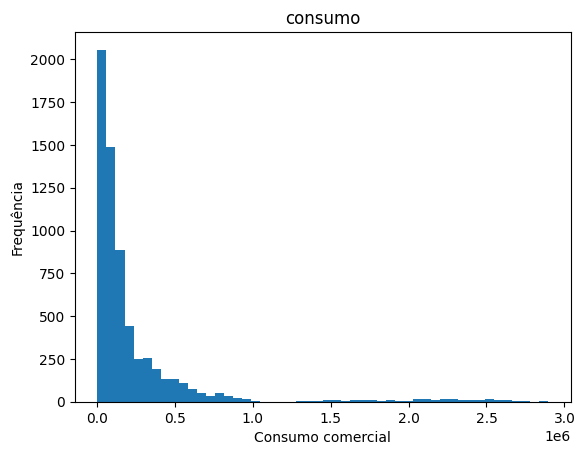

,ano,mes,numero_consumidores,consumo
count,6480.000000,6480.000000,6.480000e+03,6.480000e+03
mean,2013.500000,6.500000,1.950837e+05,2.387955e+05
std,5.766726,3.452319,2.364926e+05,4.124088e+05
min,2004.000000,1.000000,5.869000e+03,3.894000e+03
25%,2008.750000,3.750000,5.637250e+04,5.074000e+04
50%,2013.500000,6.500000,1.050735e+05,1.055420e+05
75%,2018.250000,9.250000,2.283002e+05,2.323480e+05
max,2023.000000,12.000000,1.194864e+06,2.897208e+06


In [483]:
plt_hist(consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Comercial'], 'Distribuição do consumo', 'consumo', 'Consumo comercial')
consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Comercial'].describe()

<strong>O número de consumidores comerciais de energia elétrica varia consideravelmente. A média é de aproximadamente 195 mil consumidores, com a maioria dos períodos apresentando números próximos à mediana de 105 mil consumidores. O mínimo registrado foi 5.869 consumidores, enquanto o máximo chegou a 1,19 milhão de consumidores. Isso reflete a grande diversidade no setor comercial, com uma ampla diferença entre pequenos e grandes consumidores de energia.</strong>

<strong>O consumo comercial de energia elétrica mostra grande variação entre os períodos. A média mensal de consumo é de 238,8 mil unidades, com a mediana sendo de 105,5 mil unidades, o consumo pode atingir picos elevados, com o valor máximo registrado de 2,9 milhões de unidades. O desvio padrão elevado sugere uma grande dispersão nos dados, com variações significativas entre os diferentes meses e tipos de consumidores comerciais.</strong>

##### Consumo Residencial

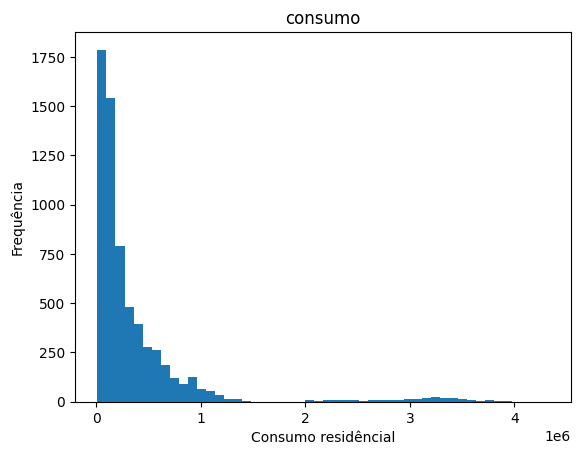

,ano,mes,numero_consumidores,consumo
count,6480.000000,6480.000000,6.480000e+03,6.480000e+03
mean,2013.500000,6.500000,2.343447e+06,3.736610e+05
std,5.766726,3.452319,3.122225e+06,5.885444e+05
min,2004.000000,1.000000,6.602100e+04,1.264500e+04
25%,2008.750000,3.750000,6.634945e+05,9.144250e+04
50%,2013.500000,6.500000,1.156076e+06,1.809670e+05
75%,2018.250000,9.250000,2.770015e+06,4.171208e+05
max,2023.000000,12.000000,1.920126e+07,4.324911e+06


In [484]:
plt_hist(consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Residencial'], 'Distribuição do consumo', 'consumo', 'Consumo residêncial')
consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Residencial'].describe()

<strong>O número de consumidores residenciais de energia elétrica apresenta uma grande variação. A média mensal é de aproximadamente 2,34 milhões de consumidores, e a mediana é de 1,16 milhão de consumidores. O valor mínimo foi de 66.021 consumidores, enquanto o valor máximo chegou a 19,2 milhões de consumidores, refletindo a grande disparidade entre áreas densamente povoadas e outras com menor concentração.</strong>

<strong>O consumo de energia elétrica no setor residencial também apresenta variações expressivas. A média mensal de consumo é de 373,7 mil unidades, enquanto a mediana é de 180,9 mil unidades, indicando que a maior parte dos períodos de consumo apresenta valores abaixo da média. O consumo máximo registrado foi de 4,32 milhões de unidades, sugerindo picos de demanda em alguns meses ou regiões. O desvio padrão elevado (588.544 unidades) revela uma grande dispersão nos dados, com variações significativas no consumo entre os diferentes meses e consumidores residenciais.</strong>

##### Consumo outros

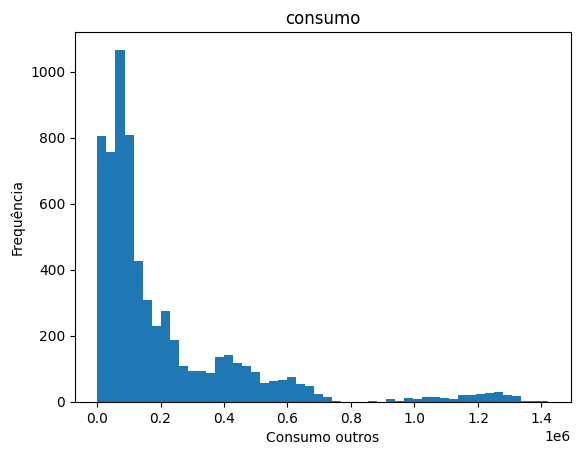

,ano,mes,numero_consumidores,consumo
count,6480.000000,6480.000000,6480.000000,6.480000e+03
mean,2013.500000,6.500000,171350.968673,2.097349e+05
std,5.766726,3.452319,175217.820070,2.518490e+05
min,2004.000000,1.000000,1710.000000,1.394000e+03
25%,2008.750000,3.750000,41705.250000,5.991500e+04
50%,2013.500000,6.500000,108286.500000,1.057325e+05
75%,2018.250000,9.250000,242085.000000,2.575290e+05
max,2023.000000,12.000000,892061.000000,1.421684e+06


In [485]:
plt_hist(consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Outros'], 'Distribuição do consumo', 'consumo', 'Consumo outros')
consumption_transformed_df[consumption_transformed_df['tipo_consumo'] == 'Outros'].describe()

<strong>O número de consumidores desse tipo de consumo de energia elétrica varia consideravelmente. A média é de aproximadamente 171 mil consumidores, com a mediana em 108 mil consumidores. O valor mínimo foi de 1.710 consumidores, enquanto o valor máximo chegou a 892.061 consumidores, o que reflete uma grande diferença na concentração de consumidores entre diferentes regiões ou tipos de estabelecimentos.</strong>

<strong>O consumo de energia elétrica para este tipo também apresenta variações significativas. A média mensal de consumo é de aproximadamente 209.735 unidades, enquanto a mediana é de 105.733 unidades, o que sugere que a maioria dos meses apresenta consumos abaixo da média. O valor máximo registrado foi de 1,42 milhões de unidades, apontando para picos de consumo em determinados períodos ou locais. O desvio padrão elevado (251.849 unidades) indica uma grande dispersão nos dados, com variações consideráveis no consumo entre os diferentes consumidores.</strong>

##### Conclusão

Semelhanças: Todos os tipos de consumo apresentam grande dispersão e variação no número de consumidores e no consumo de energia. Em todos os casos, a maioria dos consumidores tem consumo abaixo da média, com picos de consumo em determinados períodos.

Diferenças: As principais diferenças estão no número de consumidores e no nível de consumo médio. O setor industrial destaca-se pela alta demanda de energia, enquanto o setor residencial tem a maior base de consumidores e o comercial uma diversidade maior de consumidores.

Essas diferenças e semelhanças indicam que as estratégias de gestão e políticas energéticas devem ser diferenciadas para atender à diversidade de necessidades e padrões de consumo de energia em cada setor.

# Padronização e ajustes

O DataFrame foi mesclado com o DataFrame de estados e população, incorporando as colunas `state`, `region` e `population`. A coluna `month` foi atualizada para exibir o nome completo do mês em vez do valor numérico. A coluna `numero_consumidores` foi convertida para o tipo inteiro e os nomes das colunas foram atualizados para maior clareza.

In [486]:
def merge_with_states(df):
    # merge com os df de estados para agregar informações do nome do estado e região
    df = pd.merge(
        df,
        states_df[['estado','regiao','sigla']],
        left_on='sigla_uf',
        right_on='sigla'
    )

    # merge com população para agregar a quantidade da população
    return pd.merge(
        df,
        population_df[['sigla_uf', 'ano', 'populacao']],
        left_on=['sigla_uf', 'ano'],
        right_on=['sigla_uf', 'ano'],
        how='left'
    )

def transform_standardization(df):
    # transformar número do mês por nome
    df['mes'] = df['mes'].apply(lambda x: calendar.month_name[x])
    
    # cast numero_consumidores para int64
    df['numero_consumidores'] = df['numero_consumidores'].astype('Int64')
    
    # remover coluna sigla
    del df['sigla']
    
    # renomar colunas
    return df.rename(columns={
        'ano': 'year',
        'mes': 'month',
        'sigla_uf': 'uf',
        'tipo_consumo':  'type_consumption',
        'numero_consumidores': 'qty_consumers',
        'consumo': 'consumption',
        'estado': 'state',
        'regiao': 'region',
        'populacao': 'population',
    })   

In [487]:
# merge consumo com estados e população
consumption_transformed_df = merge_with_states(consumption_transformed_df)
print(f'consumption_transformed_df: {consumption_transformed_df.columns}')

consumption_total_df = merge_with_states(consumption_total_df)
print(f'consumption_total_df: {consumption_total_df.columns}')

consumption_transformed_df: Index(['ano', 'mes', 'sigla_uf', 'tipo_consumo', 'numero_consumidores',
       'consumo', 'estado', 'regiao', 'sigla', 'populacao'],
      dtype='object')
consumption_total_df: Index(['ano', 'mes', 'sigla_uf', 'tipo_consumo', 'numero_consumidores',
       'consumo', 'estado', 'regiao', 'sigla', 'populacao'],
      dtype='object')


In [488]:
consumption_transformed_df = transform_standardization(consumption_transformed_df)
consumption_total_df = transform_standardization(consumption_total_df)

print(consumption_transformed_df.columns)
print(consumption_total_df.columns)

Index(['year', 'month', 'uf', 'type_consumption', 'qty_consumers',
       'consumption', 'state', 'region', 'population'],
      dtype='object')
Index(['year', 'month', 'uf', 'type_consumption', 'qty_consumers',
       'consumption', 'state', 'region', 'population'],
      dtype='object')


In [489]:
consumption_total_df

,year,month,uf,type_consumption,qty_consumers,consumption,state,region,population
0,2004,January,AC,Total,126275,34839,Acre,Norte,630328.0
1,2004,January,AL,Total,637016,285489,Alagoas,Nordeste,2980910.0
2,2004,January,AM,Total,543155,274773,Amazonas,Norte,3138726.0
3,2004,January,AP,Total,114101,43084,Amapá,Norte,547400.0
4,2004,January,BA,Total,3502266,1444449,Bahia,Nordeste,13682074.0
...,...,...,...,...,...,...,...,...,...
6475,2023,December,RS,Total,5109494,2663137,Rio Grande do Sul,Sul,NaN
6476,2023,December,SC,Total,3447493,2505156,Santa Catarina,Sul,NaN
6477,2023,December,SE,Total,1013258,350591,Sergipe,Nordeste,NaN
6478,2023,December,SP,Total,20828948,12809741,São Paulo,Sudeste,NaN


<p>Criar funções reutilizáveis para geração de gráficos, permitindo análises flexíveis por região, ano ou
tipo de consumidor.</p>

In [490]:
consumption_transformed_df

,year,month,uf,type_consumption,qty_consumers,consumption,state,region,population
0,2004,January,RN,Outros,40857,69617,Rio Grande do Norte,Nordeste,2962107.0
1,2004,January,SP,Outros,311650,937538,São Paulo,Sudeste,39825226.0
2,2004,January,MS,Outros,56881,67601,Mato Grosso do Sul,Centro-Oeste,2230702.0
3,2004,January,SC,Outros,226165,209380,Santa Catarina,Sul,5774178.0
4,2004,January,RJ,Outros,70634,416128,Rio de Janeiro,Sudeste,15203750.0
...,...,...,...,...,...,...,...,...,...
25915,2023,December,BA,Residencial,5932740,718461,Bahia,Nordeste,NaN
25916,2023,December,PA,Residencial,2614106,478726,Pará,Norte,NaN
25917,2023,December,AC,Residencial,245699,58301,Acre,Norte,NaN
25918,2023,December,RN,Residencial,1390080,210119,Rio Grande do Norte,Nordeste,NaN


# Visualização do consumo por região

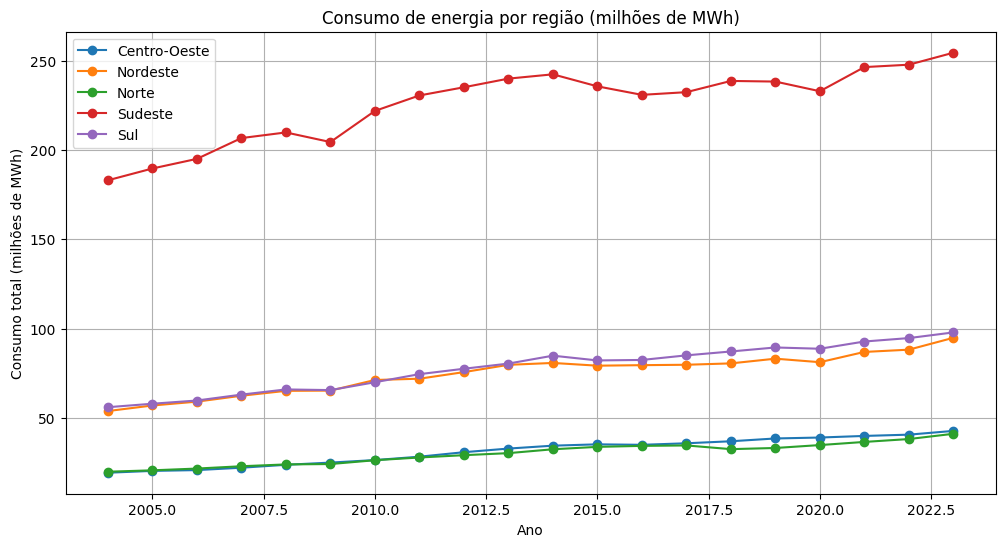

In [491]:
df_regional = consumption_total_df.copy()
df_regional['consumption_m'] = df_regional['consumption'] / 1_000_000

df_regional = df_regional.groupby(['year', 'region'])['consumption_m'].sum().unstack()

plt.figure(figsize=(12,6))
for regiao in df_regional.columns:
    plt.plot(df_regional.index, df_regional[regiao], marker='o', label=regiao)

plt.title('Consumo de energia por região (milhões de MWh)')
plt.xlabel('Ano')
plt.ylabel('Consumo total (milhões de MWh)')
plt.legend()
plt.grid(True)
plt.show()

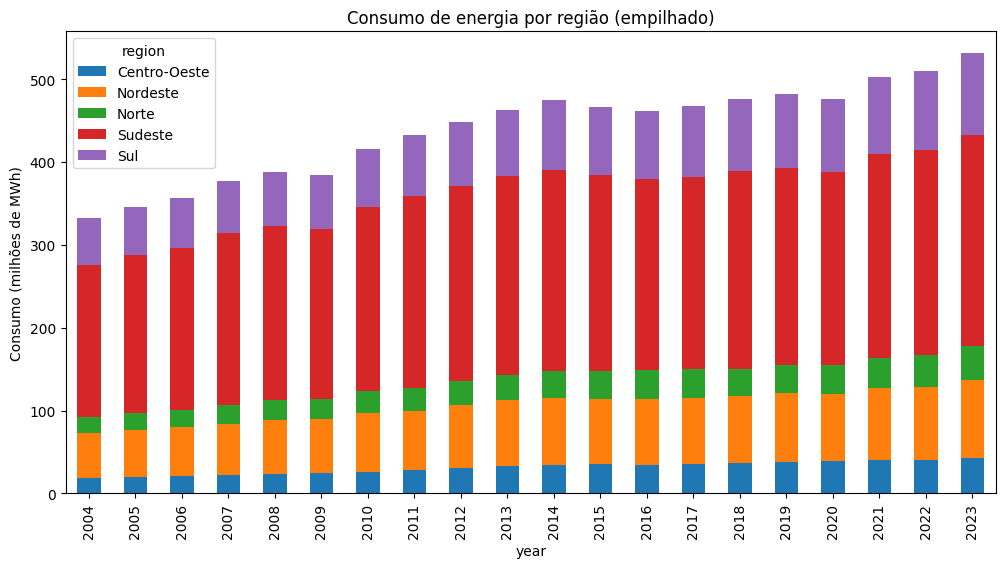

In [492]:
df_regional.plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel('Consumo (milhões de MWh)')
plt.title('Consumo de energia por região (empilhado)')
plt.show()

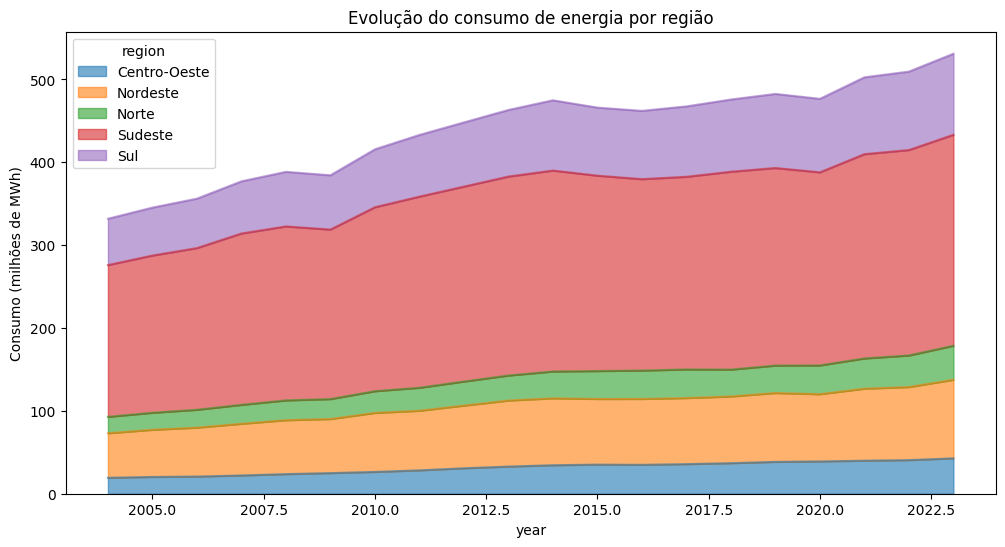

In [493]:
df_regional.plot(kind='area', figsize=(12,6), alpha=0.6)
plt.ylabel('Consumo (milhões de MWh)')
plt.title('Evolução do consumo de energia por região')
plt.show()

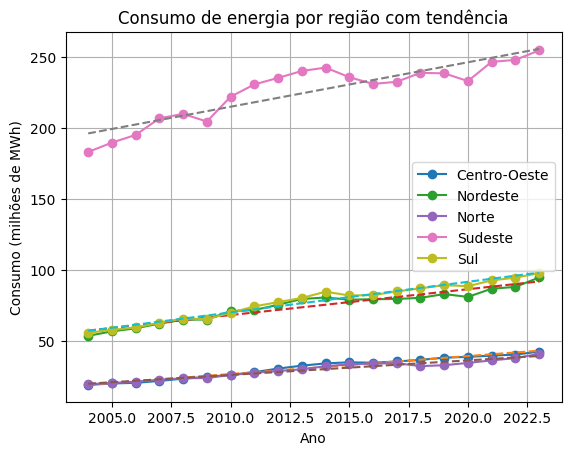

In [494]:
for regiao in df_regional.columns:
    plt.plot(df_regional.index, df_regional[regiao], marker='o', label=regiao)
    # Linha de tendência
    z = np.polyfit(df_regional.index, df_regional[regiao], 1)
    p = np.poly1d(z)
    plt.plot(df_regional.index, p(df_regional.index), linestyle='--')

plt.title('Consumo de energia por região com tendência')
plt.xlabel('Ano')
plt.ylabel('Consumo (milhões de MWh)')
plt.legend()
plt.grid(True)
plt.show()

# Analise dos dados de Pernambuco

#### Funções

In [495]:
def consumo_histoframa(df, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df.values, marker='o', linestyle='-', color='b')
    
    # configurações do gráfico
    plt.title(title, fontsize=16)
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.xticks(consumo_por_ano_ind.index, rotation=45)
    
    # Exibe o gráfico
    plt.tight_layout()
    plt.show()

def tendencia_crescimento(df, title):
    X = df.index.values.reshape(-1, 1)
    y = df.values
    
    # regressão linear
    model = LinearRegression().fit(X, y)
    
    # previsão
    y_pred = model.predict(X)
    
    # plotando a linha de tendência
    plt.plot(df.index, y, label='Consumo Real')
    plt.plot(df.index, y_pred, label='Tendência (Regressão Linear)', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Ano')
    plt.xticks(df.index, rotation=45) 
    plt.ylabel('Consumo de Energia')
    plt.legend()
    plt.show()

def percentual_crescimento(df, title):
    # cálculo do crescimento anual (variação percentual)
    df['growth'] = df.pct_change() * 100
    df['growth'].plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Ano')
    plt.ylabel('Crescimento Percentual (%)')
    plt.show()

#### Consumo de energia no estado de Pernambuco ao longo do anos

In [496]:
# filtrar dados de Pernambuco
df_pernambuco = consumption_total_df[consumption_total_df['state'] == 'Pernambuco']

df_pernambuco.head()

,year,month,uf,type_consumption,qty_consumers,consumption,state,region,population
15,2004,January,PE,Total,2323087,643100,Pernambuco,Nordeste,8323911.0
42,2004,February,PE,Total,2321673,612230,Pernambuco,Nordeste,8323911.0
69,2004,March,PE,Total,2333828,658773,Pernambuco,Nordeste,8323911.0
96,2004,April,PE,Total,2340862,674645,Pernambuco,Nordeste,8323911.0
123,2004,May,PE,Total,2284423,649436,Pernambuco,Nordeste,8323911.0


/tmp/ipykernel_8471/2094841863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pernambuco['consumption_m'] = df_pernambuco['consumption'] / 1_000_000


TypeError: '<' not supported between instances of 'str' and 'int'

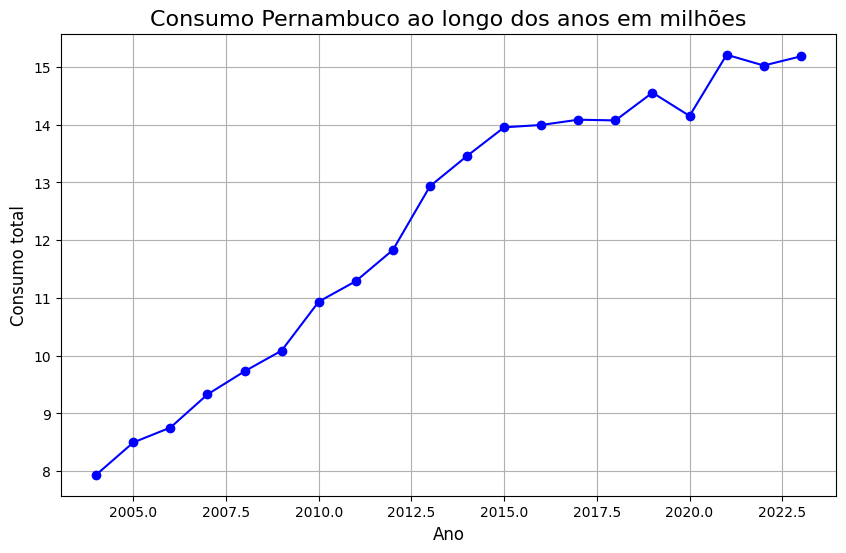

In [497]:
# agrupa por ano e soma o consumo total de cada ano na escala de milhões
df_pernambuco['consumption_m'] = df_pernambuco['consumption'] / 1_000_000
consumo_por_ano = df_pernambuco.groupby('year')['consumption_m'].sum()

# gráfico
consumo_histoframa(consumo_por_ano, 'Consumo Pernambuco ao longo dos anos em milhões', 'Consumo total')

<strong>A análise dos dados mostra que, ao longo dos anos, o número de consumidores de energia em Pernambuco apresentou uma tendência de crescimento constante. O número médio de consumidores foi de 3,26 milhões, variando de 2,26 milhões em 2004 a 4,04 milhões em 2023. Essa variação é acompanhada de um desvio padrão de 515.244, indicando uma flutuação moderada no número de consumidores ano a ano.</strong>

<strong>Quanto ao consumo total de energia, observou-se um aumento consistente ao longo do período analisado. O consumo médio foi de 1.020.985 unidades, com valores variando de 612.230 em 2004 a 1.370.287 em 2023. O desvio padrão de 205.904 sugere que, embora haja aumento, a variação no consumo total não foi excessivamente volátil, indicando um padrão de crescimento estável.</strong>

#### Crescimento total anual

In [498]:
df_pernambuco_ano = df_pernambuco.groupby('year')['consumption_m'].sum()

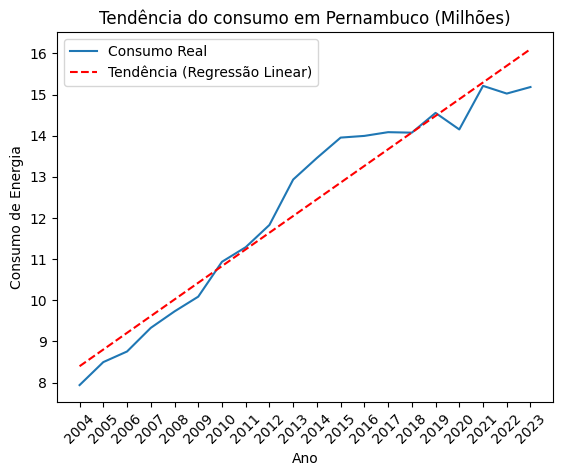

In [499]:
tendencia_crescimento(df_pernambuco_ano, 'Tendência do consumo em Pernambuco (Milhões)')


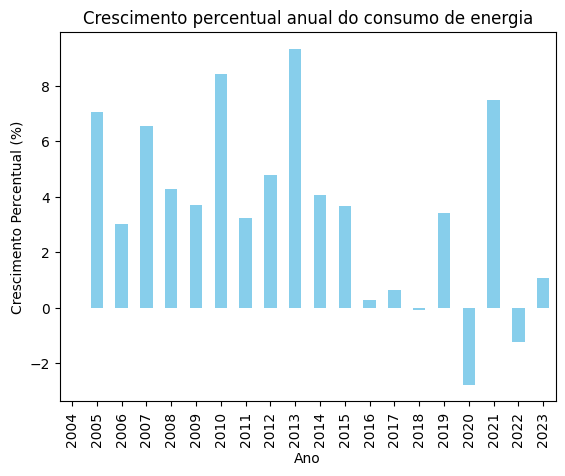

In [500]:
# gráfico percentual de crescimento
percentual_crescimento(df_pernambuco_ano, 'Crescimento percentual anual do consumo de energia')

<strong>O consumo de energia em Pernambuco teve um crescimento constante ao longo dos anos, com uma leve redução em 2020. O maior crescimento percentual foi registrado em 2021, sugerindo um pico no consumo de energia. Esses dados podem indicar uma demanda crescente por energia no estado ao longo do tempo, possivelmente associada ao aumento da população, atividades econômicas ou mudanças no consumo residencial e comercial.</strong>

#### Crescimento industrial

In [501]:
df_pernambuco_ind = consumption_transformed_df[
    (consumption_transformed_df['state'] == 'Pernambuco') &
    (consumption_transformed_df['type_consumption'] == 'Industrial')
]

# agrupa por ano e soma o consumo industrial de cada ano na escala de milhões
df_pernambuco_ind['consumption_m'] = df_pernambuco_ind['consumption'] / 1_000_000

df_pernambuco_ind.head()

/tmp/ipykernel_8471/3995999569.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pernambuco_ind['consumption_m'] = df_pernambuco_ind['consumption'] / 1_000_000


,year,month,uf,type_consumption,qty_consumers,consumption,state,region,population,consumption_m
671,2004,January,PE,Industrial,10647,165831,Pernambuco,Nordeste,8323911.0,0.165831
701,2004,February,PE,Industrial,10348,165846,Pernambuco,Nordeste,8323911.0,0.165846
716,2004,March,PE,Industrial,10317,183040,Pernambuco,Nordeste,8323911.0,0.183040
746,2004,April,PE,Industrial,10254,177795,Pernambuco,Nordeste,8323911.0,0.177795
771,2004,May,PE,Industrial,10158,179917,Pernambuco,Nordeste,8323911.0,0.179917


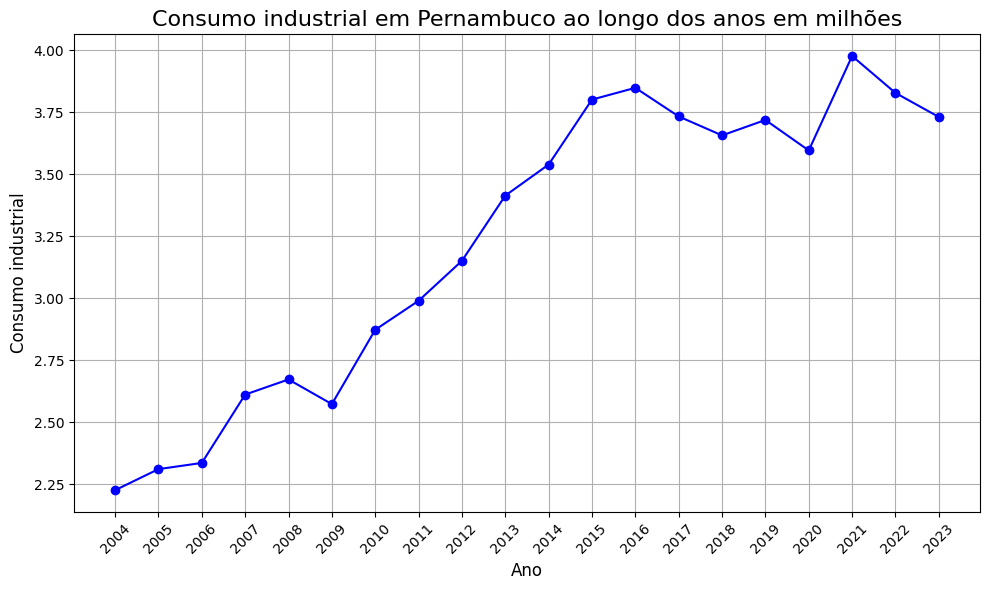

In [502]:
consumo_por_ano_ind = df_pernambuco_ind.groupby('year')['consumption_m'].sum()
consumo_histoframa(consumo_por_ano_ind, 'Consumo industrial em Pernambuco ao longo dos anos em milhões', 'Consumo industrial')

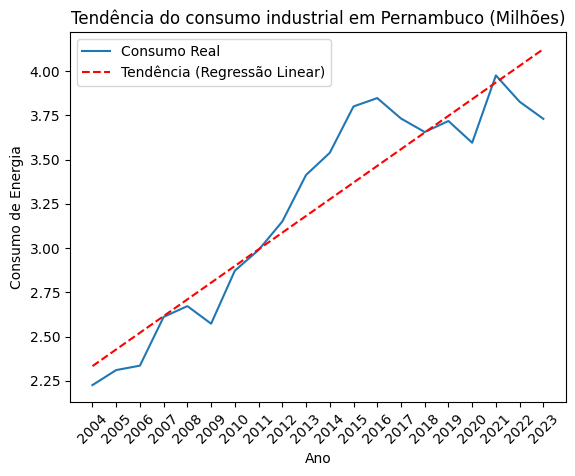

In [503]:
# gráfico de tendência de consumo industrial
tendencia_crescimento(consumo_por_ano_ind, 'Tendência do consumo industrial em Pernambuco (Milhões)')

<strong>O consumo de energia no setor industrial de Pernambuco, medido em milhões de unidades, apresentou um crescimento geral ao longo dos anos, iniciando em 2,226 milhões em 2004 e atingindo 3,977 milhões em 2021. Em 2020, houve uma leve redução para 3,596 milhões, provavelmente devido a impactos econômicos (pandemia), mas em 2021, o consumo se recuperou, alcançando o maior valor da série histórica. Após 2021, o consumo caiu ligeiramente em 2022 e 2023, mas a tendência geral permanece de aumento ao longo do período.</strong>

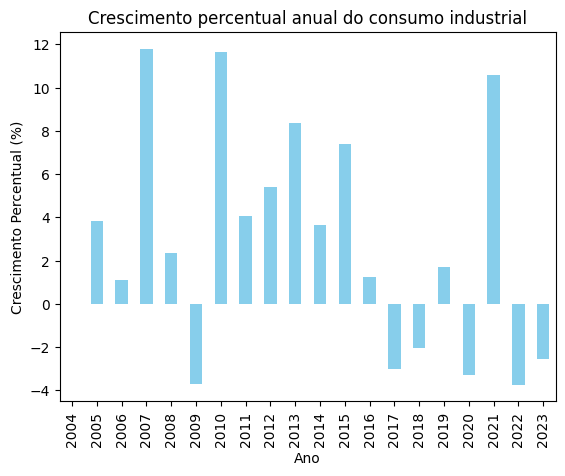

In [504]:
# gráfico percentual de crescimento
percentual_crescimento(consumo_por_ano_ind, 'Crescimento percentual anual do consumo industrial')

<strong>O consumo de energia no setor industrial de Pernambuco mostra um crescimento constante de 2004 a 2021, subindo de 2,226 milhões para 3,977 milhões. Embora tenha ocorrido uma leve queda em 2020 (para 3,596 milhões), o consumo se recuperou em 2021. O crescimento anual foi positivo na maioria dos anos, com destaque para o aumento de 7,4% entre 2014 e 2015 e de 10,6% entre 2020 e 2021. A tendência geral reflete uma expansão do setor industrial, com algumas flutuações devido a fatores econômicos e externos.</strong>

#### Crescimento residêncial

In [505]:
df_pernambuco_res = consumption_transformed_df[
    (consumption_transformed_df['state'] == 'Pernambuco') &
    (consumption_transformed_df['type_consumption'] == 'Residencial')
]

# agrupa por ano e soma o consumo residêncial de cada ano na escala de milhões
df_pernambuco_res['consumption_m'] = df_pernambuco_res['consumption'] / 1_000_000

df_pernambuco_ind.head()

/tmp/ipykernel_8471/179673420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pernambuco_res['consumption_m'] = df_pernambuco_res['consumption'] / 1_000_000


,year,month,uf,type_consumption,qty_consumers,consumption,state,region,population,consumption_m
671,2004,January,PE,Industrial,10647,165831,Pernambuco,Nordeste,8323911.0,0.165831
701,2004,February,PE,Industrial,10348,165846,Pernambuco,Nordeste,8323911.0,0.165846
716,2004,March,PE,Industrial,10317,183040,Pernambuco,Nordeste,8323911.0,0.183040
746,2004,April,PE,Industrial,10254,177795,Pernambuco,Nordeste,8323911.0,0.177795
771,2004,May,PE,Industrial,10158,179917,Pernambuco,Nordeste,8323911.0,0.179917


TypeError: '<' not supported between instances of 'str' and 'int'

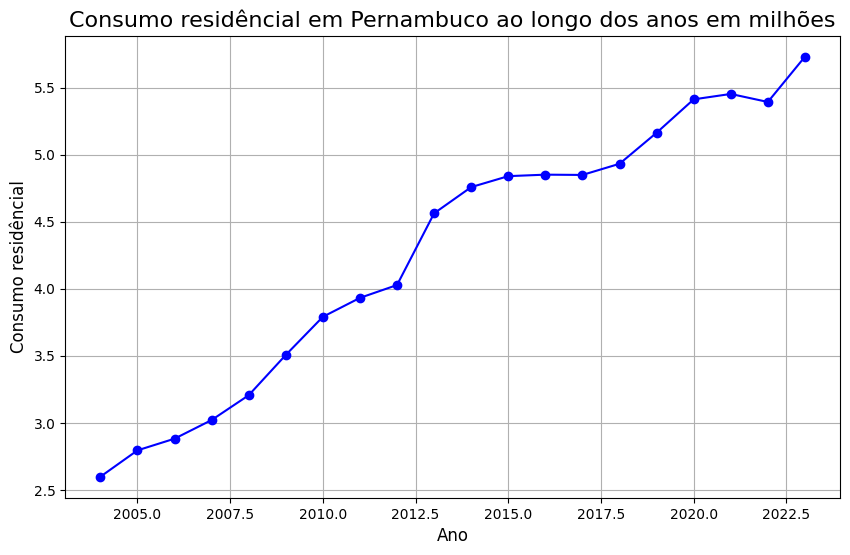

In [506]:
consumo_por_ano_res = df_pernambuco_res.groupby('year')['consumption_m'].sum()
consumo_histoframa(consumo_por_ano_res, 'Consumo residêncial em Pernambuco ao longo dos anos em milhões', 'Consumo residêncial')

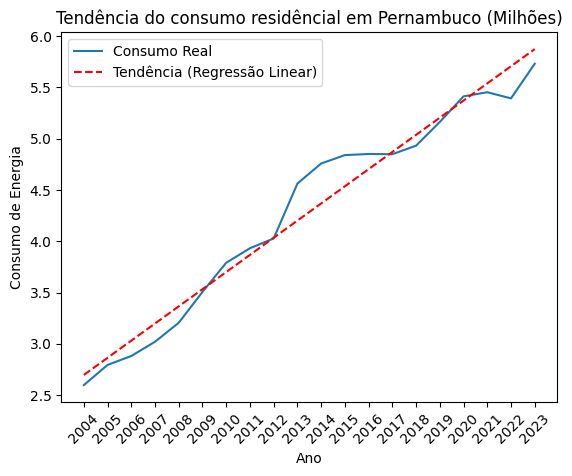

In [507]:
# gráfico de tendência de consumo residêncial
tendencia_crescimento(consumo_por_ano_res, 'Tendência do consumo residêncial em Pernambuco (Milhões)')

<strong>O consumo de energia residencial em Pernambuco apresentou um crescimento constante de 2004 a 2023, passando de 2,599 milhões em 2004 para 5,731 milhões em 2023. O aumento mais acentuado ocorreu entre 2008 e 2010, com o consumo subindo de 3,206 milhões para 3,791 milhões. A partir de 2020, o crescimento continuou, embora com uma leve redução em 2022 (para 5,394 milhões), antes de retomar o aumento em 2023, alcançando o maior valor da série. Essa tendência reflete um aumento contínuo na demanda de energia elétrica no setor residencial ao longo dos anos.</strong>

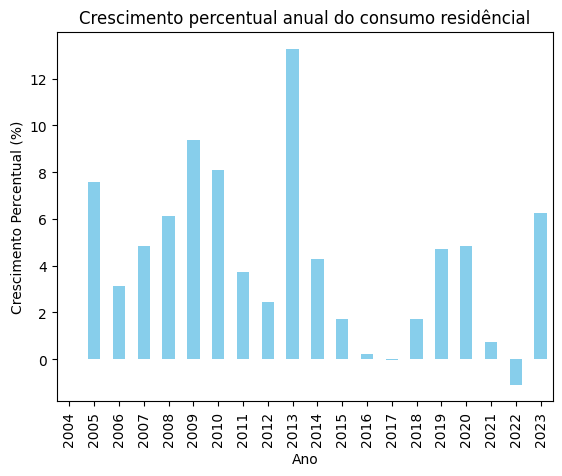

In [508]:
# gráfico percentual de crescimento
percentual_crescimento(consumo_por_ano_res, 'Crescimento percentual anual do consumo residêncial')

<strong>O crescimento percentual do consumo de energia residencial em Pernambuco variou ao longo dos anos. A partir de 2004, o consumo aumentou anualmente, com destaque para 2005, quando houve um crescimento de 7,57% em relação ao ano anterior. Outros anos de crescimento significativo ocorreram em 2007 (5,07%) e 2019 (4,8%), refletindo períodos de expansão maior. No entanto, em 2020, houve um crescimento de 4,6%, seguido por uma leve desaceleração em 2022 (com crescimento de 0,1%), antes de uma recuperação em 2023 (com aumento de 6,3%). Essa variação pode ser atribuída a fatores econômicos, demográficos e mudanças no padrão de consumo, com picos de crescimento seguidos de períodos de estabilidade ou desaceleração.</strong>

#### Conclusão

O consumo de energia em Pernambuco, tanto no setor residencial quanto no industrial, mostra crescimento contínuo ao longo dos anos, com algumas variações. O setor residencial apresentou um aumento constante, com picos de crescimento em anos como 2005, 2019, e 2023, refletindo um padrão de demanda estável e gradual ao longo do tempo. A única leve desaceleração ocorreu em 2022, quando o crescimento foi mais modesto.

Por outro lado, o setor industrial mostrou flutuações mais expressivas, com um crescimento mais significativo em anos como 2015 e 2021, seguidos por uma queda em 2020. Essa queda pode ser atribuída aos impactos da pandemia de COVID-19, que afetou a produção e o consumo de energia industrial naquele ano. Após isso, houve uma recuperação no crescimento em 2021, refletindo uma retomada gradual da atividade econômica.

# Conclusão

Os conjuntos de dados utilizados — consumo_energia_eletrica.csv, estado_regiao.csv e populacao.csv — fornecem informações detalhadas sobre o consumo de energia elétrica no Brasil, integrando aspectos temporais, geográficos e demográficos. Esses dados permitem análises exploratórias, estudos regionais e modelagem de séries temporais.

Qualidade e Estrutura dos Dados
A análise inicial identificou 1.017 registros duplicados (~2,5% do total) e 12.960 valores ausentes (~32,5%) no campo numero_consumidores. A distribuição do consumo apresenta assimetria positiva, com média (~607.686) superior à mediana (~219.767), indicando outliers superiores. Esses valores extremos refletem estados ou períodos com consumo elevado, enquanto valores muito baixos podem representar registros atípicos ou estados com menor demanda.

Para garantir consistência analítica, foram removidos registros duplicados, resultando em 38.880 observações válidas, e registros de consumo próprio foram excluídos, evitando inferências distorcidas entre categorias de consumo (residencial, comercial e industrial).

Análise do Consumo em Pernambuco
A análise detalhada do estado permitiu comparar o consumo residencial e industrial ao longo de 2004 a 2023:

Consumo Residencial:
<ul>
<li>Crescimento constante de 2,598 milhões MWh em 2004 para 5,731 milhões MWh em 2023.</li>    
<li>Crescimento anual médio de aproximadamente 4,5%, com picos de 7,57% em 2005 e 6,3% em 2023.</li>    
<li>Leve desaceleração em 2022, quando o aumento anual foi modesto, sugerindo estabilidade temporária no padrão de consumo.</li>
</ul>

Consumo Industrial:
<ul>
<li>Maior variabilidade ao longo do período, com crescimento expressivo entre 2014 e 2021.</li>
<li>Queda em 2020, atribuída aos impactos da pandemia de COVID-19, seguida de recuperação em 2021.</li>
<li>Crescimento anual médio próximo a 3,5%, porém mais sensível a fatores externos, evidenciando a volatilidade do setor industrial.</li>
</ul>

Considerações Técnicas
<ul>
<li>O consumo residencial apresenta trajectória previsível, enquanto o industrial apresenta flutuações significativas, especialmente em anos de crise ou eventos extraordinários.</li>
<li>A análise de séries temporais e o cálculo de crescimento percentual anual permitiram identificar picos, quedas e tendências de longo prazo.</li>
<li>A presença de outliers superiores reforça a necessidade de métodos estatísticos robustos em modelagem, para evitar distorções causadas por registros extremos.</li>
</ul>

Conclusão Geral
O estudo evidencia que o consumo de energia em Pernambuco segue padrões distintos entre setores:
<ul>
<li>O residencial cresce de forma gradual e contínua, refletindo aumento constante da demanda doméstica.</li>
<li>O industrial é mais volátil, com quedas em anos específicos, como 2020, devido à pandemia, e recuperação subsequente.</li>
</ul>

Esses resultados fornecem insights valiosos para planejamento energético, políticas públicas e estratégias de eficiência, destacando a importância de considerar a heterogeneidade setorial e a influência de eventos externos na análise de consumo de energia. Além disso, os dados indicam que a modelagem e projeções futuras devem incorporar variabilidade histórica e outliers para maior robustez e confiabilidade.

Aluno: Caio Coutinho